In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.model.data import __version__

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

from src.base import logger
from src.config import get_config
from src.model.data import make_dataset
from src.model.features import build_features
from src.model.preprocessing import PreProcessor

from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor

#from xgboost import XGBClassifier


pd.options.display.max_columns = None

%config IPCompleter.use_jedi=False

In [5]:
# Getting data information
data_config = get_config(filename="config/model.yaml")
features_config = get_config(filename="config/features.yaml")

# Construct the dataset
data  = make_dataset(data_config, download_bases=False)
X,y = build_features(data)

# Splitting in train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42)

# Train preprocessor
preprocessor = PreProcessor(features_config)
preprocessor.fit(X_train)

# Tranforming features
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

In [6]:
data_train = X_train.assign(y=y_train)

data_train.corr()['y'] #520687

n_parking_spaces    0.524207
n_bathrooms         0.549283
n_bedrooms          0.482339
area                0.246370
y                   1.000000
Name: y, dtype: float64

In [96]:
np.corrcoef(X_train['n_bedrooms'], y_train)

array([[1.        , 0.45909141],
       [0.45909141, 1.        ]])

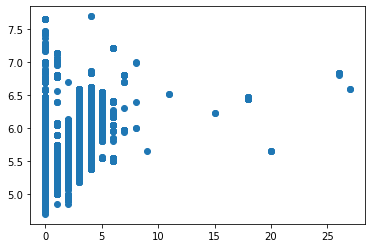

In [98]:
plt.scatter(X_train['n_bedrooms'], y_train)

plt.show()

<AxesSubplot:>

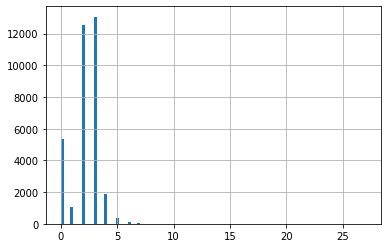

In [102]:
X_train['n_bedrooms'].hist(bins=100)

In [4]:
X.head(2)

,id,search_id,id_zap,type,n_parking_spaces,n_bathrooms,n_bedrooms,area,n_floors,units_on_floor,n_suites,state,city,neighborhood,street,longitude,latitude,condo_fee,iptu,resale,buildings,plan_only,search_date
0,1,2503300374__2021_06_04_00_23_37,2503300374,HOME,2.0,3.0,3.0,100.0,NaN,0,1.0,MG,Poços de Caldas,Jardim Das Hortênsias,None,NaN,NaN,NaN,NaN,0,0,0,2021-06-04
1,2,2462358530__2021_06_04_00_23_37,2462358530,APARTMENT,2.0,3.0,3.0,128.0,NaN,0,1.0,MG,Poços de Caldas,Centro,Rua Assis Figueiredo,-46.56683,-21.780617,0.0,0.0,0,0,0,2021-06-04


<AxesSubplot:>

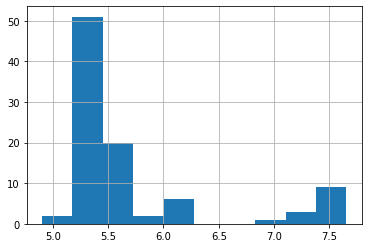

In [12]:
y_train[X_train['area']==0].hist()

In [13]:
X_train[X_train['n_bedrooms']==0]

,n_parking_spaces,n_bathrooms,n_bedrooms,area
24283,0.0,0.0,0.0,600.0
45168,0.0,0.0,0.0,432.0
42382,0.0,0.0,0.0,601.0
34355,0.0,0.0,0.0,718.0
28549,0.0,0.0,0.0,49.0
...,...,...,...,...
2453,0.0,0.0,0.0,754.0
41504,0.0,0.0,0.0,450.0
16183,0.0,0.0,0.0,400.0
17017,0.0,0.0,0.0,439.0


In [10]:
X_train[X_train['area']==0]

,n_parking_spaces,n_bathrooms,n_bedrooms,area
12041,0.0,0.0,0.0,0.0
40176,0.0,0.0,0.0,0.0
46239,0.0,0.0,0.0,0.0
43426,0.0,0.0,0.0,0.0
43039,0.0,0.0,0.0,0.0
...,...,...,...,...
6006,0.0,0.0,0.0,0.0
45558,0.0,0.0,0.0,0.0
27633,0.0,0.0,0.0,0.0
38688,0.0,0.0,0.0,0.0


In [21]:
X['type'].unique()

array(['HOME', 'APARTMENT', 'OFFICE', 'RESIDENTIAL_ALLOTMENT_LAND',
       'CONDOMINIUM', 'SHED_DEPOSIT_WAREHOUSE', 'TWO_STORY_HOUSE',
       'COMMERCIAL_ALLOTMENT_LAND', 'PENTHOUSE', 'BUSINESS',
       'COUNTRY_HOUSE', 'ALLOTMENT_LAND', 'HOTEL', 'FARM',
       'COMMERCIAL_BUILDING', 'COMMERCIAL_PROPERTY', 'FLAT', 'KITNET'],
      dtype=object)

In [31]:
X

,id,search_id,id_zap,type,n_parking_spaces,n_bathrooms,n_bedrooms,area,n_floors,units_on_floor,n_suites,state,city,neighborhood,street,longitude,latitude,condo_fee,iptu,resale,buildings,plan_only,search_date
0,1,2503300374__2021_06_04_00_23_37,2503300374,HOME,2.0,3.0,3.0,100.0,NaN,0,1.0,MG,Poços de Caldas,Jardim Das Hortênsias,None,NaN,NaN,NaN,NaN,0,0,0,2021-06-04
1,2,2462358530__2021_06_04_00_23_37,2462358530,APARTMENT,2.0,3.0,3.0,128.0,NaN,0,1.0,MG,Poços de Caldas,Centro,Rua Assis Figueiredo,-46.566830,-21.780617,0.0,0.0,0,0,0,2021-06-04
2,3,70958901__2021_06_04_00_23_37,70958901,APARTMENT,2.0,4.0,3.0,115.0,NaN,0,1.0,MG,Poços de Caldas,Jardim Elvira Dias,None,NaN,NaN,636.0,0.0,0,0,0,2021-06-04
3,4,2500808474__2021_06_04_00_23_40,2500808474,HOME,2.0,3.0,2.0,130.0,NaN,0,2.0,MG,Poços de Caldas,Jardim Amaryllis,None,NaN,NaN,0.0,0.0,0,0,0,2021-06-04
4,5,2503298489__2021_06_04_00_23_40,2503298489,HOME,2.0,1.0,3.0,147.0,NaN,0,2.0,MG,Poços de Caldas,Residencial Morumbi,None,NaN,NaN,NaN,NaN,0,0,0,2021-06-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46379,46388,2565333431__2022_06_04_12_50_51,2565333431,RESIDENTIAL_ALLOTMENT_LAND,NaN,NaN,NaN,450.0,NaN,0,NaN,MG,Poços de Caldas,,,-46.564793,-21.790032,0.0,0.0,0,0,0,2022-06-04
46380,46389,2565333588__2022_06_04_12_50_51,2565333588,BUSINESS,50.0,18.0,18.0,1030.0,NaN,0,18.0,MG,Poços de Caldas,Bortolan,,-46.632519,-21.800174,0.0,0.0,0,0,0,2022-06-04
46382,46391,2563036993__2022_06_04_12_51_15,2563036993,ALLOTMENT_LAND,NaN,0.0,0.0,0.0,NaN,0,NaN,MG,Poços de Caldas,Centro,Avenida João Pinheiro,-46.572020,-21.785873,0.0,0.0,0,0,0,2022-06-04
46383,46392,2565495224__2022_06_04_12_51_15,2565495224,HOME,2.0,1.0,4.0,318.0,NaN,0,1.0,MG,Poços de Caldas,São Benedito,,-46.569688,-21.832478,0.0,0.0,0,0,0,2022-06-04


In [35]:
X

,id,search_id,id_zap,type,n_parking_spaces,n_bathrooms,n_bedrooms,area,n_floors,units_on_floor,n_suites,state,city,neighborhood,street,longitude,latitude,condo_fee,iptu,resale,buildings,plan_only,search_date
0,1,2503300374__2021_06_04_00_23_37,2503300374,HOME,2.0,3.0,3.0,100.0,NaN,0,1.0,MG,Poços de Caldas,Jardim Das Hortênsias,None,NaN,NaN,NaN,NaN,0,0,0,2021-06-04
1,2,2462358530__2021_06_04_00_23_37,2462358530,APARTMENT,2.0,3.0,3.0,128.0,NaN,0,1.0,MG,Poços de Caldas,Centro,Rua Assis Figueiredo,-46.566830,-21.780617,0.0,0.0,0,0,0,2021-06-04
2,3,70958901__2021_06_04_00_23_37,70958901,APARTMENT,2.0,4.0,3.0,115.0,NaN,0,1.0,MG,Poços de Caldas,Jardim Elvira Dias,None,NaN,NaN,636.0,0.0,0,0,0,2021-06-04
3,4,2500808474__2021_06_04_00_23_40,2500808474,HOME,2.0,3.0,2.0,130.0,NaN,0,2.0,MG,Poços de Caldas,Jardim Amaryllis,None,NaN,NaN,0.0,0.0,0,0,0,2021-06-04
4,5,2503298489__2021_06_04_00_23_40,2503298489,HOME,2.0,1.0,3.0,147.0,NaN,0,2.0,MG,Poços de Caldas,Residencial Morumbi,None,NaN,NaN,NaN,NaN,0,0,0,2021-06-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46379,46388,2565333431__2022_06_04_12_50_51,2565333431,RESIDENTIAL_ALLOTMENT_LAND,NaN,NaN,NaN,450.0,NaN,0,NaN,MG,Poços de Caldas,,,-46.564793,-21.790032,0.0,0.0,0,0,0,2022-06-04
46380,46389,2565333588__2022_06_04_12_50_51,2565333588,BUSINESS,50.0,18.0,18.0,1030.0,NaN,0,18.0,MG,Poços de Caldas,Bortolan,,-46.632519,-21.800174,0.0,0.0,0,0,0,2022-06-04
46382,46391,2563036993__2022_06_04_12_51_15,2563036993,ALLOTMENT_LAND,NaN,0.0,0.0,0.0,NaN,0,NaN,MG,Poços de Caldas,Centro,Avenida João Pinheiro,-46.572020,-21.785873,0.0,0.0,0,0,0,2022-06-04
46383,46392,2565495224__2022_06_04_12_51_15,2565495224,HOME,2.0,1.0,4.0,318.0,NaN,0,1.0,MG,Poços de Caldas,São Benedito,,-46.569688,-21.832478,0.0,0.0,0,0,0,2022-06-04


In [36]:
X.assign(price=y).groupby('type').agg(
    price = ('price',lambda x: np.mean(10**x)),
    n_parking_spaces = ('n_parking_spaces',lambda x: np.mean(x)),
    n_bathrooms = ('n_bathrooms',lambda x: np.mean(x)),
    n_bedrooms = ('n_bedrooms',lambda x: np.mean(x)),
    n_floors = ('n_floors',lambda x: np.mean(x)),
    

).round(1)

,price,n_parking_spaces,n_bathrooms,n_bedrooms,n_floors
type,,,,,
ALLOTMENT_LAND,664490.2,0.0,0.0,0.0,NaN
APARTMENT,411500.2,1.3,1.6,2.4,7.2
BUSINESS,910162.3,6.0,2.3,2.4,NaN
COMMERCIAL_ALLOTMENT_LAND,1918813.0,0.0,0.0,0.0,NaN
COMMERCIAL_BUILDING,6088888.9,12.2,2.6,10.0,NaN
COMMERCIAL_PROPERTY,1404586.2,0.6,1.6,0.7,NaN
CONDOMINIUM,948740.7,2.1,2.5,2.9,NaN
COUNTRY_HOUSE,1563407.5,3.4,2.4,2.8,NaN
FARM,7169139.9,3.2,2.5,2.7,3.0


In [ ]:
BUSINESS_TYPES = [
    'SHED_DEPOSIT_WAREHOUSE',
    'COMMERCIAL_ALLOTMENT_LAND',
    'BUSINESS',
    'COMMERCIAL_PROPERTY',
    'COMMERCIAL_BUILDING'
]


TYPE_MAPPING = {
    'TWO_STORY_HOUSE': 'HOME',
    'CONDOMINIUM': 'HOME'
    'FLAT': 'APARTMENT',
    'KITNET': 'APARTMENT',
    'RESIDENTIAL_ALLOTMENT_LAND': 'ALLOTMENT_LAND',
    'COMMERCIAL_ALLOTMENT_LAND': 'ALLOTMENT_LAND',
}

In [42]:
100*X['type'].value_counts(normalize=True)

APARTMENT                     49.934658
HOME                          30.621624
RESIDENTIAL_ALLOTMENT_LAND    12.863739
CONDOMINIUM                    2.066998
COUNTRY_HOUSE                  1.106465
ALLOTMENT_LAND                 0.618575
FARM                           0.607684
OFFICE                         0.457397
SHED_DEPOSIT_WAREHOUSE         0.457397
COMMERCIAL_ALLOTMENT_LAND      0.400767
BUSINESS                       0.335424
PENTHOUSE                      0.191671
COMMERCIAL_PROPERTY            0.189493
FLAT                           0.067520
HOTEL                          0.028315
KITNET                         0.021781
COMMERCIAL_BUILDING            0.019603
TWO_STORY_HOUSE                0.010890
Name: type, dtype: float64

array(['COMMERCIAL_ALLOTMENT_LAND', 'BUSINESS', 'FARM', 'ALLOTMENT_LAND'],
      dtype=object)

/home/risknow/Documentos/testes/model-pc-prices/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: supplied range of [-inf, 10.397177190355384] is not finite

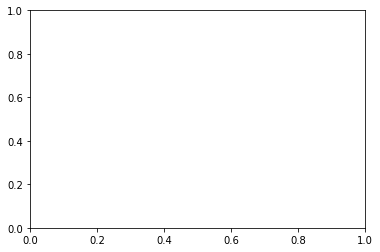

In [9]:
np.log(X_train['area']).hist(bins=100)

plt.show()

In [8]:
# data_config = get_config(filename="config/model.yaml")

# features_config = get_config(filename="config/features.yaml")

# X,y  = make_dataset(data_config, download_bases=False)

# X,y = build_features(X, y)

# X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, test_size=0.25, random_state=42)

# preprocessor = PreProcessor(features_config)

# preprocessor.fit(X_train)

# X_train = preprocessor.transform(X_train)

# X_test = preprocessor.transform(X_test)

# classifier = LogisticRegression(C=5)

# classifier.fit(X_train, y_train)

# classifier.predict_proba(X_test)[:,1]

# accuracy_score(y_test,classifier.predict(X_test))

0.68

In [9]:
from dotenv import load_dotenv
import psycopg2
import os
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
assert load_dotenv()

engine = create_engine(
    "postgresql://{user}:{password}@{host}:{port}/{database}".format(
        user=os.getenv("DB_USERNAME"),
        password=os.getenv("DB_PASSWORD"),
        host=os.getenv("DB_HOST"),
        port=os.getenv("DB_PORT"),
        database=os.getenv("DB_NAME"),
    )
)

# amenities = pd.read_sql("""
# with tab as (
#     select *  from pocos_de_caldas.imoveis i limit 100
# )
# select search_id, jsonb_array_elements(amenities) as amenity, price from tab t
# """, engine)

# pois = pd.read_sql("""
# with tab as (
#     select *  from pocos_de_caldas.imoveis i limit 100
# )
# select search_id, jsonb_array_elements(pois_list) as pois, price from tab t
# """, engine)

In [10]:
from basix.parquet import write as to_parquet

In [10]:
df = pd.read_sql("""
    select
        id
        , search_id
        , search_date 
        , id_zap
        , type
        , jsonb_array_elements(amenities) as amenity
        , price
    from pocos_de_caldas.imoveis
""", engine)

# df['search_date'] = df['search_date'].dt.date

# to_parquet(df, "data/raw/", overwrite=True, partition_cols = ["search_date"] )



In [11]:
df

,id,search_id,search_date,id_zap,type,amenity,price
0,2,2462358530__2021_06_04_00_23_37,2021-06-04,2462358530,APARTMENT,GATED_COMMUNITY,950000.0
1,2,2462358530__2021_06_04_00_23_37,2021-06-04,2462358530,APARTMENT,ELEVATOR,950000.0
2,2,2462358530__2021_06_04_00_23_37,2021-06-04,2462358530,APARTMENT,SERVICE_AREA,950000.0
3,2,2462358530__2021_06_04_00_23_37,2021-06-04,2462358530,APARTMENT,BALCONY,950000.0
4,2,2462358530__2021_06_04_00_23_37,2021-06-04,2462358530,APARTMENT,MOUNTAIN_VIEW,950000.0
...,...,...,...,...,...,...,...
132651,46392,2565495224__2022_06_04_12_51_15,2022-06-04,2565495224,HOME,KITCHEN,2250000.0
132652,46392,2565495224__2022_06_04_12_51_15,2022-06-04,2565495224,HOME,POOL,2250000.0
132653,46392,2565495224__2022_06_04_12_51_15,2022-06-04,2565495224,HOME,BACKYARD,2250000.0
132654,46392,2565495224__2022_06_04_12_51_15,2022-06-04,2565495224,HOME,SERVICE_AREA,2250000.0
